## 简单估计

以下数据演示了目标先静止后匀速运动。观测的数据是有误差的。

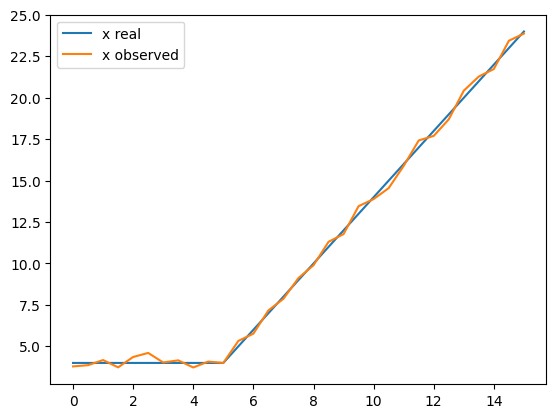

In [267]:
import matplotlib.pyplot as plt
import numpy as np
# set numpy default dtype to float32


M = 10
N = 31
v_real = np.array([0.] * M + [2.] * (N - M))
# add some noise
t = np.linspace(0, 15, N)
x_real = np.zeros(N)

x_real[0] = 4
for i in range(1, N):
    x_real[i] = x_real[i - 1] + v_real[i - 1] * (t[i] - t[i - 1])
x_obs = x_real + np.random.normal(0, 0.3, N)

# plot them


def plot_tuple(tup_xyname):
    for x, y, name in tup_xyname:
        plt.plot(x, y, label=name)
    plt.legend()
    plt.show()


plot_tuple([(t, x_real, 'x real'), (t, x_obs, 'x observed')])

用平均法估计位置，平滑但滞后，且不会收敛。

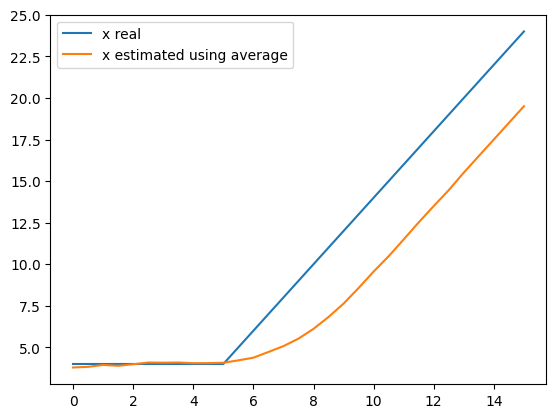

In [268]:
# 用平均法估计位置
K = 10


def moving_ave(x, i, k):
    if i < k:
        return np.mean(x[:i + 1])
    return np.mean(x[i - k + 1:i + 1])


x_esti = [moving_ave(x_obs, i, K) for i in range(N)]
plot_tuple([(t, x_real, 'x real'), (t, x_esti, 'x estimated using average')])

用帧差法估计速度，非常不平滑。

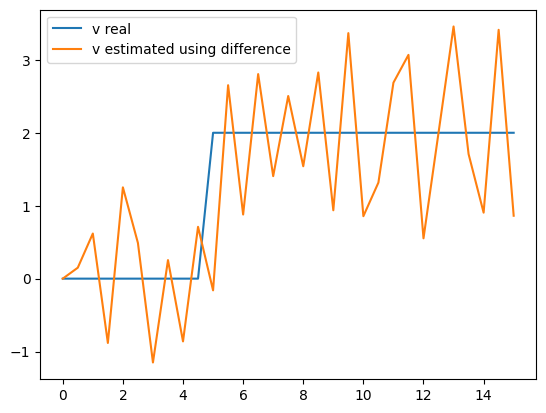

In [269]:
# 使用帧差法估计速度
v_esti_dif = [0] + [(x_obs[i] - x_obs[i - 1]) / (t[i] - t[i - 1])
                    for i in range(1, len(x_obs))]
plot_tuple(
    [(t, v_real, 'v real'), (t, v_esti_dif, 'v estimated using difference')])

用平均帧差法估计速度，相对平滑但滞后。

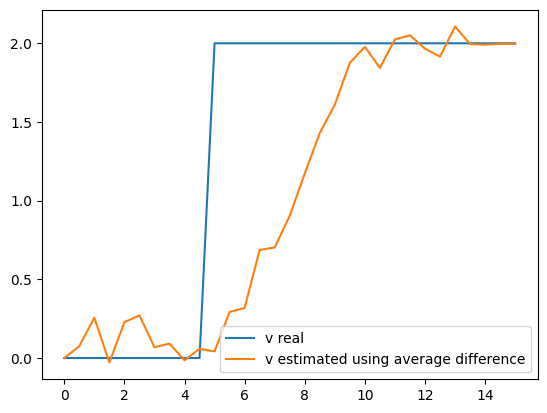

In [270]:
# 平均帧差法估计速度
v_esti_dif_ave = [moving_ave(v_esti_dif, i, K) for i in range(N)]
plot_tuple([(t, v_real, 'v real'), (t, v_esti_dif_ave,
           'v estimated using average difference')])

## 卡尔曼滤波估计

使用卡尔曼滤波估计，根据经验数值调节 $P$ 和 $Q$，即可同时得到位置和速度的估计，其较为平滑且滞后较少，最终可收敛于正确值。

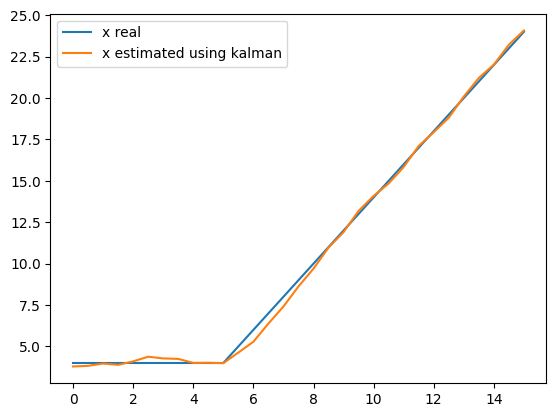

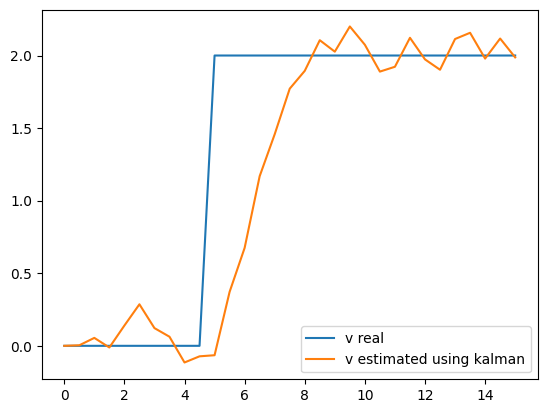

In [271]:
class Kalman:
    def __init__(self, x, P, H):
        self.x = x  # [state * 1]
        self.P = P  # [state * state]
        self.H = H  # [obs * state]

    def predict(self, F, Q):
        self.x = F @ self.x
        self.P = F @ self.P @ F.T + Q

    def update(self, z, R):
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = self.P - K @ self.H @ self.P


# P 初值的设定我们稍后讨论.
kalman = Kalman(np.array([0, 0]), P=np.array(
    [[1e6, 0], [0, 0]]), H=np.array([[1, 0]]))
pos_v_kalman = []
for i in range(N):
    kalman.predict(F=np.array(
        [[1, t[i] - t[i - 1] if i > 0 else 0], [0, 1]]), Q=np.array([[0.1, 0], [0, 10]]))
    kalman.update(z=np.array([x_obs[i]]), R=np.eye(1) * 50)
    pos_v_kalman.append(kalman.x)

plot_tuple([(t, x_real, 'x real'), (t, [x[0]
           for x in pos_v_kalman], 'x estimated using kalman')])
plot_tuple([(t, v_real, 'v real'), (t, [x[1]
           for x in pos_v_kalman], 'v estimated using kalman')])

## 扩展卡尔曼滤波估计

如果状态转移函数或者状态和观测量之间的转移函数无法使用矩阵描述，则可以将转移函数一阶泰勒展开为近似矩阵。这里使用 torch 的 jabobian 求这两个函数的近似矩阵.

当然，如果转移是线性的，EKF 也能用。我们首先演示 EKF 解决上述平移估计问题.

In [115]:
import torch
from torch.autograd.functional import jacobian


class Ekf:
    def __init__(self, x, P, measure_func):
        self.x = x  # [state * 1]
        self.P = P  # [state * state]
        self.measure_func = measure_func

    def predict(self, predict_func, Q):
        self.x = predict_func(self.x)
        F = jacobian(predict_func, self.x)
        self.P = F @ self.P @ F.T + Q

    def update(self, z, R):
        y = z - self.measure_func(self.x)
        H = jacobian(self.measure_func, self.x)
        S = H @ self.P @ H.T + R
        K = self.P @ H.T @ torch.inverse(S)
        self.x = self.x + K @ y
        self.P = self.P - K @ H @ self.P

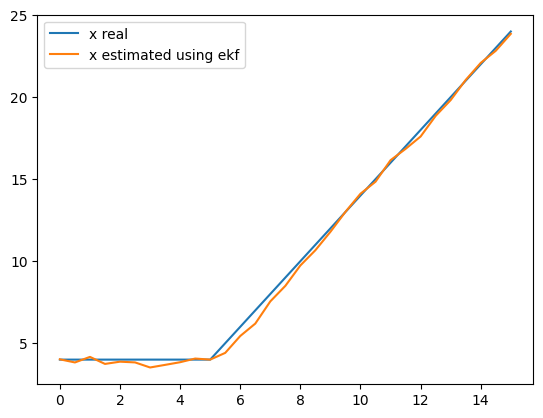

In [116]:
# 保持 x[0] 单元素的额外一个维度; 输入 x shape 为 (2,) 而不是 (2, 1)
ekf = Ekf(torch.tensor([0., 0.]), torch.tensor(
    [[1e6, 0], [0, 1e3]]), lambda x: torch.stack((x[0], )))
pos_v_ekf = []
for i in range(N):
    ekf.predict(
        predict_func=lambda x: torch.stack(
            (x[0] + x[1] * (t[i] - t[i - 1]), x[1])),
        Q=torch.tensor([[0.1, 0], [0, 10]])
    )
    ekf.update(z=torch.tensor(
        [x_obs[i]], dtype=torch.float32), R=torch.eye(1) * 50.0)
    pos_v_ekf.append(ekf.x)
plot_tuple([(t, x_real, 'x real'), (t, [x[0].item()
           for x in pos_v_ekf], 'x estimated using ekf')])

可以看到和 Kalman 表现完全一致. 理论上此处 jabobian 和原始 Kalman 的 F 和 H 矩阵是一样的.

下面是一个日地引力模拟，首先生成真实数据，真实数据是滤波器无法得知的：

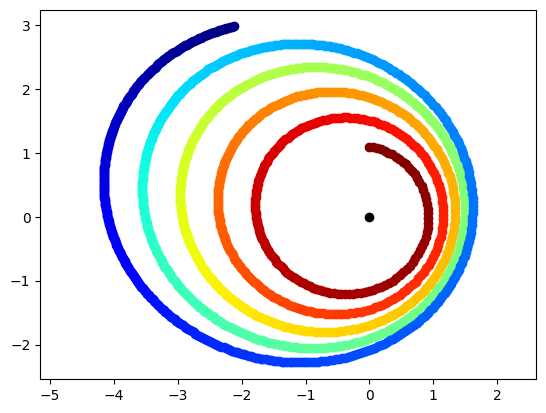

In [117]:
GM = 1.7
pos_real = [np.array([0., 1.1])]
v_real = [np.array((1.2, -0.2))]
t_real = [0]
sim_t = 0.05
N = 1500
damp = 0.99997
# GM 引力下自由运动
for i in range(1, N):
    t_real.append(t_real[i - 1] + sim_t)
    a = -GM * pos_real[-1] / np.linalg.norm(pos_real[-1]) ** 3
    v_real.append((v_real[-1] + a * sim_t) * damp)
    # x += (v + v') / 2 * t
    pos_real.append(pos_real[-1] + (v_real[-1] + v_real[-2]) / 2 * sim_t)


def plot2d(pos):
    # plot with changing color
    colors = plt.cm.jet(np.linspace(0, 1, len(pos)))[::-1]
    for i, p in enumerate(pos):
        plt.scatter(p[0], p[1], color=colors[i])
    plt.scatter(0, 0, color='black')
    # make x y ratio equal
    plt.axis('equal')
    plt.show()


plot2d(pos_real[::1])

然后采样位置. 我们的采样时间间隔较大，且有一定误差. Ekf 内部状态为 xy 位置和速度.

这里为什么这里采样极坐标而不是直角坐标 xy 呢？

- 有时候只能采样极坐标.
- 有时候你确定传感器对极角的估计很准确，但距离估计不准确，则你的观测数据设置为极坐标可以更好地设置方差.
    - 比如 PNP 对球坐标 pitch yaw 估计很准确，但距离不准.

下面我们就来模拟一下这种情况.

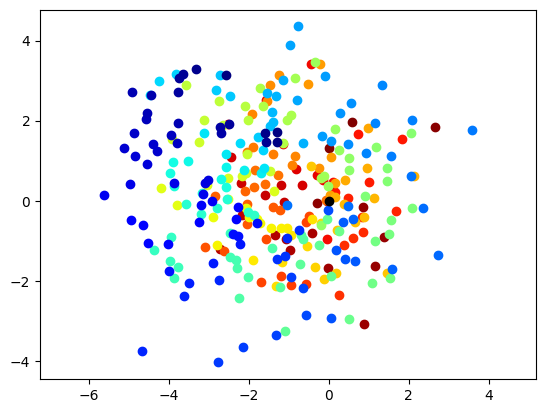

In [209]:
sample_interval = 5
pos_sample = pos_real[::sample_interval]
so_polar = [np.array([np.linalg.norm(pos), np.arctan2(pos[1], pos[0])])
            for pos in pos_sample]
# 极角方差远小于距离方差
sample_polor = [np.random.normal(p, [1.00, 0.001]) for p in so_polar]
sample_vis_xy = [np.array([p[0] * np.cos(p[1]), p[0] * np.sin(p[1])])
                 for p in sample_polor]
t_sample = t_real[::sample_interval]
plot2d(sample_vis_xy)

接下来使用非线性预测 + 非线性观测的 EKF 估计每隔时刻的位置和速度.

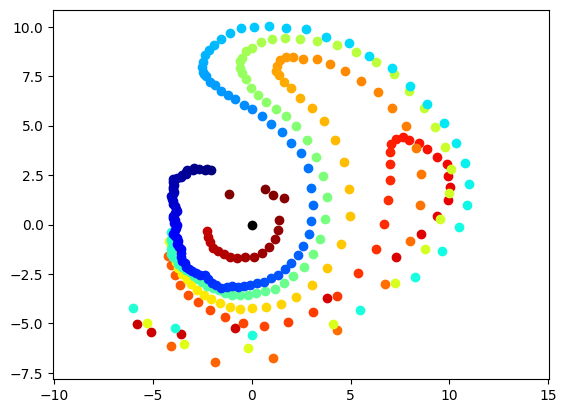

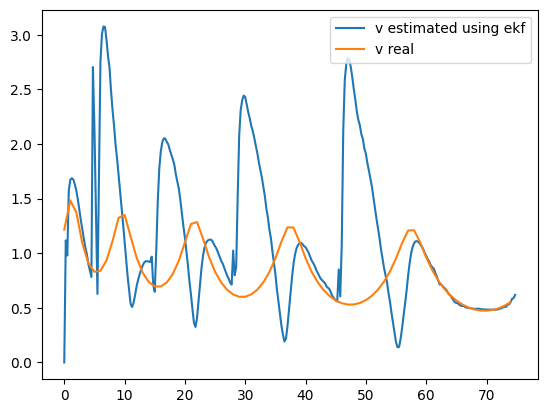

In [262]:
# state: x, y, vx, vy
# known: GM
# obs: r, theta
# predict will consider acceleration
# used in kalman
import copy
Qx = 1e-6
Qv = 2e-4
ekf_R_rho = 1.0123847012340870
ekf_R_theta = 0.010213047

def predict_func_with_dt(dt):
    def predict_func(x: torch.Tensor):
        pos = x[:2]
        v = x[2:]
        a = -GM * pos / torch.norm(pos) ** 3
        nxt_v = v + a * dt
        return torch.cat((pos + (v + nxt_v) / 2 * dt, nxt_v))
    return predict_func


def measure_func(x: torch.Tensor):
    pos = x[:2]
    return torch.stack((torch.norm(pos), torch.atan2(pos[1], pos[0])))


ori_ekf =  Ekf(
    torch.tensor([-1., 0., 0., 0.]),
    torch.tensor([[1.0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]),
    measure_func
)
ekf = copy.deepcopy(ori_ekf)
pos_ekf = []
pos_v_ekf = []
for i in range(len(sample_polor)):
    ekf.predict(predict_func_with_dt(t_sample[i] - t_sample[i - 1] if i > 0 else 0), torch.tensor(
        [[Qx, 0, 0, 0], [0, Qx, 0, 0], [0, 0, Qv, 0], [0, 0, 0, Qv]]))
    ekf.update(torch.tensor(
        sample_polor[i], dtype=torch.float32), torch.tensor([[ekf_R_rho, 0], [0, ekf_R_theta]]))
    pos_ekf.append(ekf.x[:2].detach().numpy())
    pos_v_ekf.append(ekf.x[2:].detach().numpy())

plot2d(pos_ekf)
# show v and v_real
plot_tuple([(t_sample, [np.linalg.norm(v) for v in pos_v_ekf], 'v estimated using ekf'),
           (t_real[::20], [np.linalg.norm(v) for v in v_real[::20]], 'v real')])

出 Bug 了. 上图中速度和位置估计每隔一圈就有概率突变，原因是极角在 -pi 到 pi 附近角度突变，例如 ekf 内部 xy 转换出的极角为 -179 度，而观测数据为 179 度，泰勒展开失效.

可将传入数据强制转换为与内部转换的角度接近的角度，解决问题.

In [263]:
def closest_angle(target, src):
    return target + (src - target + np.pi) % (2 * np.pi) - np.pi


closest_angle(4 * np.pi - 0.01, 0.01), closest_angle(-np.pi +
                                                     0.01, np.pi - 0.01)

(12.576370614359172, -3.151592653589793)

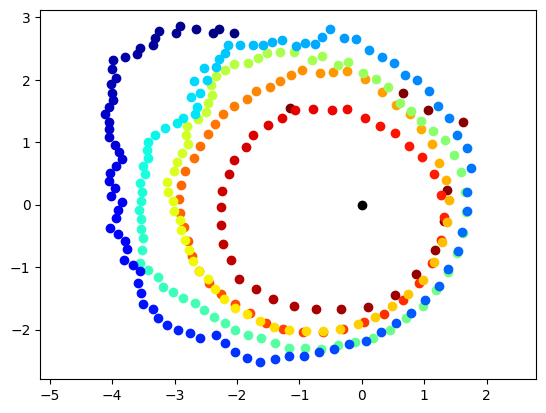

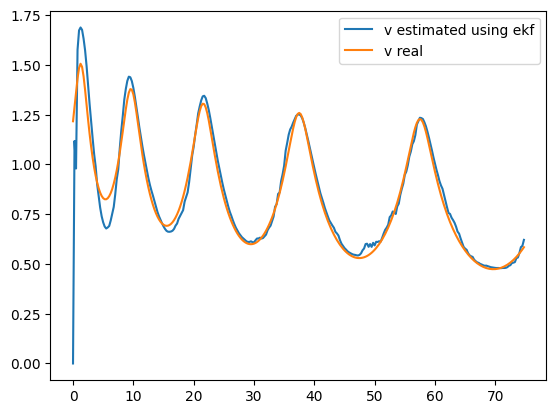

In [264]:
ekf = copy.deepcopy(ori_ekf)
pos_ekf = []
pos_v_ekf = []
for i in range(len(sample_polor)):
    ekf.predict(
        predict_func_with_dt(t_sample[i] - t_sample[i - 1] if i > 0 else 0),
        Q=torch.tensor([[Qx, 0, 0, 0], [0, Qx, 0, 0],
                       [0, 0, Qv, 0], [0, 0, 0, Qv]])
    )
    pos = ekf.x[:2].detach().numpy()
    theta_close = closest_angle(np.arctan2(pos[1], pos[0]), sample_polor[i][1])
    ekf.update(
        z=torch.tensor((sample_polor[i][0], theta_close), dtype=torch.float32),
        R=torch.tensor([[ekf_R_rho, 0], [0, ekf_R_theta]])
    )
    pos_ekf.append(ekf.x[:2].detach().numpy())
    pos_v_ekf.append(ekf.x[2:].detach().numpy())

plot2d(pos_ekf)
# show v and v_real
plot_tuple([(t_sample, [np.linalg.norm(v) for v in pos_v_ekf], 'v estimated using ekf'),
           (t_real[::sample_interval], [np.linalg.norm(v) for v in v_real[::sample_interval]], 'v real')])

极角可以大胆跟随，位置较平滑，速度估计也很准确. 来看看非线性预测 + 线性观测的表现.

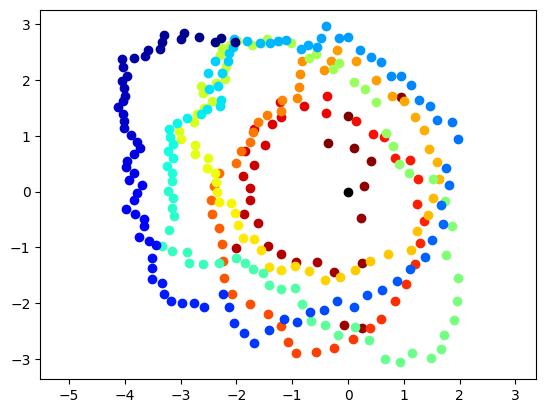

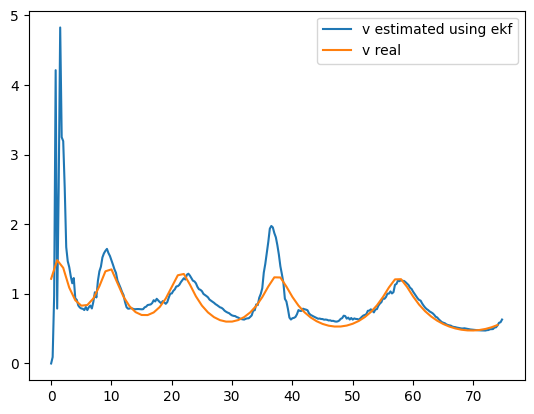

In [265]:
# state: x, y, vx, vy
# known: GM
# obs: r, theta
# predict will consider acceleration
# used in kalman
import copy
ekf_R_x = 1.09817234 / 2
ekf_R_y = 1.0128374 / 2

def predict_func_with_dt(dt):
    def predict_func(x: torch.Tensor):
        pos = x[:2]
        v = x[2:]
        a = -GM * pos / torch.norm(pos) ** 3
        nxt_v = v + a * dt
        return torch.cat((pos + (v + nxt_v) / 2 * dt, nxt_v))
    return predict_func


def measure_func(x: torch.Tensor):
    pos = x[:2]
    return pos


ori_ekf =  Ekf(
    torch.tensor([-1., 0., 0., 0.]),
    torch.tensor([[1.0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]),
    measure_func
)
ekf = copy.deepcopy(ori_ekf)
pos_ekf = []
pos_v_ekf = []
for i in range(len(sample_polor)):
    ekf.predict(predict_func_with_dt(t_sample[i] - t_sample[i - 1] if i > 0 else 0), torch.tensor(
        [[Qx, 0, 0, 0], [0, Qx, 0, 0], [0, 0, Qv, 0], [0, 0, 0, Qv]]))
    ekf.update(torch.tensor(
        sample_vis_xy[i], dtype=torch.float32), torch.tensor([[ekf_R_x, 0], [0, ekf_R_y]]))
    pos_ekf.append(ekf.x[:2].detach().numpy())
    pos_v_ekf.append(ekf.x[2:].detach().numpy())

plot2d(pos_ekf)
# show v and v_real
plot_tuple([(t_sample, [np.linalg.norm(v) for v in pos_v_ekf], 'v estimated using ekf'),
           (t_real[::20], [np.linalg.norm(v) for v in v_real[::20]], 'v real')])


EKF 跟的越紧，估计方差越大；跟的越慢，估计方差越小，需要经验调参，选择平衡点。

上述实验中，观测方差实际上可拆分为极角的小方差和距离的大方差，但若观测量为 xy 而非极角，且方差设为 Rx Ry 常数，这个平衡点就会更差，跟的慢且方差大，但也没有差到不能用.

## 应用场景下 P 的初值设定

应用 Kalman Filter 时可设置 alive 机制，若长时间未更新卡尔曼滤波或者第一次 `update()`，则可在 `update()` 前强制将内部状态先更新为新观测值，以及将 $P$ 协方差矩阵设置为单位矩阵，或单位矩阵 $\times 10^9$.

see: https://github.com/julyfun/robotoy/blob/main/robotoy/kalman/linear_kalman.py

如果不想设置 alive 机制，则协方差初值可以设置为位置 $10^6$，速度 $10^3$. 
- 如速度项设置为 $0$ 则一开始几帧跟的很慢，如果设置为 $10^6$ 则前几帧会过于相信位置帧差的速度，导致前几帧速度浮动大.
- 这种不一定是最优解，在不同观测数据中最优解不一样.